In [1]:
import os 
os.environ["ISISROOT"] = "/usgs/cpkgs/anaconda3_linux/envs/isis3.9.0"

from matplotlib import pyplot as plt

from plio.io.io_gdal import GeoDataset 
import numpy as np

from autocnet.cg import change_detection as cd
from autocnet.utils.utils import bytescale 

from plio.io.io_gdal import GeoDataset
import pysis
from pysis import isis
from pysis.exceptions import ProcessError


In [2]:
roi1_proj = "/scratch/krodriguez/hirise/ESP_031022_1415_RED1.stitched.norm.34517_37165.proj.cub"
roi2_proj = "/scratch/krodriguez/hirise/ESP_014038_1415_RED0.stitched.norm.30421_33069.proj.cub"

In [3]:
# Run to create the subsolar azimuth band.  There is currently no option to output directly as array
try:
    isis.phocube(from_=roi1_proj, to='out.cub', subsolargroundazimuth=True)
except ProcessError as e:
    print(e.stderr)

In [4]:
ssa = GeoDataset('out.cub')

In [5]:
ssa_array = ssa.read_array()
ssa_slice = ssa_array[700:1200,1100:1500]

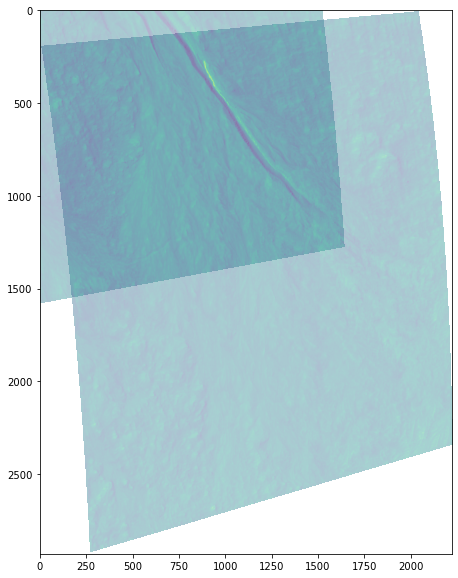

In [6]:
roi1_proj_geo = GeoDataset(roi1_proj)
roi2_proj_geo = GeoDataset(roi2_proj)
isis_null = pysis.specialpixels.SPECIAL_PIXELS['Real']['Null']

proj_array1 = roi1_proj_geo.read_array()
proj_array2 = roi2_proj_geo.read_array()

proj_array1[proj_array1 == isis_null] = np.nan
proj_array2[proj_array2 == isis_null] = np.nan

plt.figure(0, figsize=(10, 10))
plt.imshow(proj_array1, alpha=.4)
plt.imshow(proj_array2, alpha=.4)

In [7]:
slice1 = proj_array1[700:1200,1100:1500]
slice2 = proj_array2[700:1200,1100:1500]

In [43]:
t1,bdiff = cd.blob_detector(slice1, slice2, np.mean(ssa_slice), cd.image_diff, max_sigma=30, 
                         num_sigma=5, threshold=.45, angle_tolerance=20, overlap=.5, dist_upper_bound=10, subtractive=True)

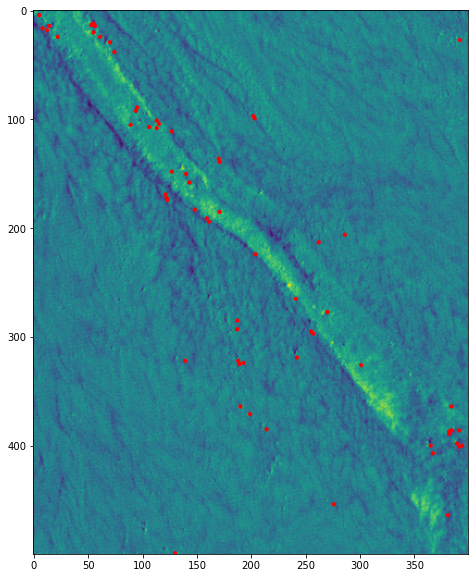

In [44]:
fig = plt.figure(0, figsize=(10, 10))
axis = fig.add_subplot(1,1,1)
plt.imshow(bdiff, alpha=1)
for pt1 in t1.geometry:
    x, y = pt1.xy
    c = plt.Circle((x[0], y[0]), 1, color='red', linewidth=2, fill=False)
    axis.add_patch(c)
